# Top

In [1]:
import urllib
import pyodbc
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import matplotlib as mpl
import statsmodels.api as sm
import multiprocessing as mp

from multiprocessing import Process
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from importlib import reload
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2 as ctable

In [2]:
%load_ext line_profiler

In [3]:
with open('dbmi-aetna-cxn-str') as f:
    cxn_params = f.read().strip()
    gmw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=gmw3')
    aetna_raw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=AetnaDataWarehouse')
    hy_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=hy180')
    
engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % gmw_cxn_str, connect_args = {'autocommit':True})
cxn = engine.connect()
ins = sqla.inspect(engine)

hy_engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % hy_cxn_str, connect_args = {'autocommit': True, 'fast_executemany': True}, pool_size=100)
hy_cxn = hy_engine.connect()

In [5]:
# Print table col names + example row

tab = 'ConceptMedication'
print([r['name'] for r in ins.get_columns(tab)])
pd.read_sql("select top 10 * from %s order by newid()" % tab, cxn)

['NationalDrugCode', 'NdcDescription', 'NumberOfPatients', 'NumberOfClaims', 'NumberOfMaintenancePatients', 'NumberOfMaintenanceClaims', 'FirstDispenseDate', 'LastDispenseDate', 'FirstPaidDate', 'LastPaidDate', 'TotalQuantity', 'TotalDaysSupply', 'MaxTotalQuantity', 'MaxTotalDaysSupply', 'MaxQuantity', 'MaxDaysSupply', 'TotalDeductibleAmount', 'TotalMemberOutOfPocketAmount', 'TotalPaidAmount', 'MaxTotalDeductibleAmount', 'MaxTotalMemberOutOfPocketAmount', 'MaxTotalPaidAmount']


,NationalDrugCode,NdcDescription,NumberOfPatients,NumberOfClaims,NumberOfMaintenancePatients,NumberOfMaintenanceClaims,FirstDispenseDate,LastDispenseDate,FirstPaidDate,LastPaidDate,...,MaxTotalQuantity,MaxTotalDaysSupply,MaxQuantity,MaxDaysSupply,TotalDeductibleAmount,TotalMemberOutOfPocketAmount,TotalPaidAmount,MaxTotalDeductibleAmount,MaxTotalMemberOutOfPocketAmount,MaxTotalPaidAmount
0,781341315,AMPICILLIN INJ 2GM,1,5,0,0,2011-03-01,2011-04-08,2011-03-25,2011-04-13,...,112.0,29,32.0,8,0.00,1.10,2747.88,0.00,1.10,2747.88
1,40986003109,NICOTINE POL GUM 2MG MINT,2,2,0,0,2016-05-24,2016-12-10,2016-05-24,2016-12-10,...,40.0,4,40.0,4,0.00,0.00,14.33,0.00,0.00,9.30
2,47781026305,OXYCODONE TAB 5MG,1570,5013,0,0,2014-04-25,2017-06-30,2014-04-25,2017-06-30,...,9690.0,930,540.0,90,3869.84,17249.18,77168.29,513.72,603.97,2551.69
3,10019002232,KETOROLAC INJ 60MG/2ML,29,32,0,0,2008-03-13,2012-08-30,2008-03-13,2012-08-30,...,20.0,30,20.0,30,9.00,147.88,191.38,9.00,10.00,29.80
4,781197101,DESIPRAMINE TAB 10MG,2078,9718,2078,9718,2008-01-02,2017-05-26,2008-01-02,2017-06-16,...,28350.0,4220,720.0,90,15042.91,102093.98,286972.54,627.47,1535.00,22936.43
5,89117000001,NASONEB NSL MIS REPLACEM,1,1,0,0,2014-02-21,2014-02-21,2014-02-21,2014-02-21,...,1.0,1,1.0,1,0.00,153.28,0.00,0.00,153.28,0.00
6,332415530,AMOXICILLIN SUS 250/5ML,2,2,0,0,2008-02-27,2011-01-06,2008-02-27,2012-03-12,...,150.0,10,150.0,10,0.00,11.40,10.00,0.00,11.40,10.00
7,49452439502,MEBENDAZOLE POW,3,19,0,0,2013-07-21,2013-11-10,2013-11-10,2015-11-16,...,9.0,9,3.0,1,0.00,180.56,0.00,0.00,153.00,0.00
8,68645032054,OMEPRAZOLE CAP 20MG,5329,59384,5329,59384,2012-04-17,2017-04-05,2012-04-17,2017-04-22,...,7800.0,3960,720.0,365,53827.40,357705.79,620360.81,1522.80,1522.80,4607.26
9,68330000210,CEFTRIAXONE INJ 500MG,20,23,0,0,2008-10-17,2010-12-17,2008-12-07,2011-06-11,...,8.0,7,7.0,7,40.89,89.32,1012.24,40.89,40.89,193.43


# Population characteristics

<BarContainer object of 122 artists>

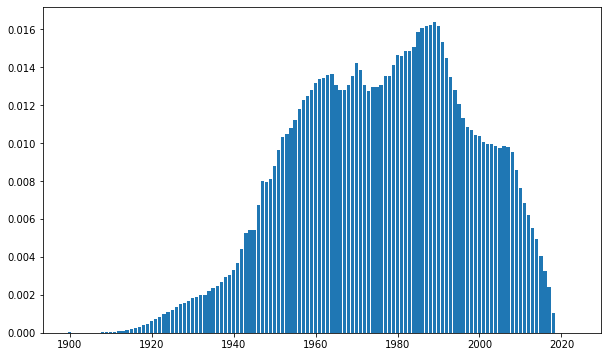

In [6]:
# patients by birth year
query = 'select BirthYearMinus1900+1900 as byear,count(MemberNum) as membersFromBY from Member with (nolock) group by BirthYearMinus1900'
patients_by_birthyear = pd.read_sql(query, con=cxn, index_col='byear')
patients_by_birthyear.dropna(axis=0, inplace=True)
patients_by_birthyear.sort_values(by='byear', ascending=True,inplace=True)
patients_by_birthyear['propTotalPatients'] = patients_by_birthyear.membersFromBY / patients_by_birthyear.membersFromBY.sum()

plt.figure(figsize=(10, 6))
plt.bar(x=patients_by_birthyear.index, height=patients_by_birthyear.propTotalPatients, align='center')

## Glucose tests by age

In [7]:
# temp table for glucose tests per patient
glucose_lab_procs = ('82947', '')
tmp_query = ("select MemberNum, datepart(yyyy, DateServiceStarted) as year, LineLevelProcedureCode as cpt "
             " into #hytmp from ObservationProcedure with (nolock) "
             " where LineLevelProcedureCodeType='C' and LineLevelProcedureCode in %s;" % str(glucose_lab_procs))
cxn.execute(tmp_query)

# count glucose measurements in each byear bucket per year
query = ("select t.year, count(*) as tests, t1.BirthYearMinus1900 + 1900 as byear"
        " from (select MemberNum, BirthYearMinus1900 from Member) as t1 "
        " join #hytmp as t on (t.MemberNum=t1.MemberNum)"
        " group by year, t1.BirthYearMinus1900;")
glucose_per_year = pd.read_sql(query, cxn, index_col=['byear'])

normalized_gpy = glucose_per_year.join(patients_by_birthyear, on='byear')
normalized_gpy['testsPerMember'] = normalized_gpy.tests / normalized_gpy.membersFromBY
normalized_gpy['age'] = normalized_gpy.year - normalized_gpy.index

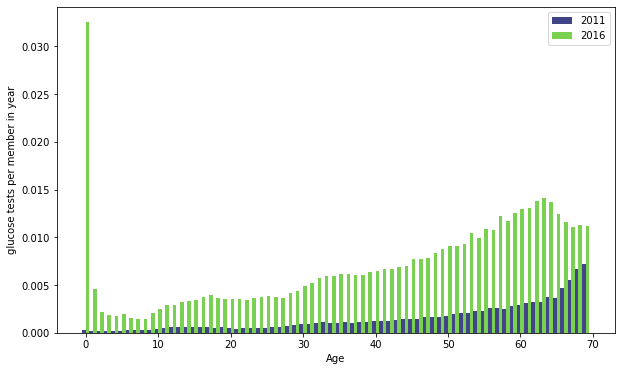

In [8]:
y_old = 2011
y_new = 2016
age_thres = 70

old_data = normalized_gpy.loc[(normalized_gpy.year == y_old) & (normalized_gpy.age < age_thres)].sort_values(by='byear')
new_data = normalized_gpy.loc[(normalized_gpy.year == y_new) & (normalized_gpy.age < age_thres)].sort_values(by='byear')

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
old_bars = ax.bar(x=old_data.age.values-.5, height=old_data.testsPerMember, align='edge', width=.5, color=mpl.cm.viridis(.2))
new_bars = ax.bar(x=new_data.age.values, height=new_data.testsPerMember, align='edge', width=.5, color=mpl.cm.viridis(.8))
# ax.bar(x=patients_by_birthyear.index, height=patients_by_birthyear.propTotalPatients, align='center')

plt.xlabel('Age')
plt.ylabel('glucose tests per member in year')
ax.legend(handles=[old_bars, new_bars], labels=[y_old, y_new])

## Age

In [18]:
def age_histogram(group_table=None, cxn=cxn, ax=None, **plot_params):
    if group_table is None:
        query = ("select 119 - BirthYearMinus1900 as age, count(*) as ageCount"
                " from gmw3.dbo.Member"
                " group by BirthYearMinus1900")
    else:
        query = ("select 119 - BirthYearMinus1900 as age, count(*) as ageCount"
                " from gmw3.dbo.Member as t1"
                " inner join %s as t2"
                " on t1.MemberNum=t2.MemberNum"
                " group by BirthYearMinus1900"
                % group_table)
        
    results = pd.read_sql(query, cxn)
    if not ax: ax = plt.subplot(111)
    ax.bar(x=results.age.values, height=results.ageCount, **plot_params)
    return results

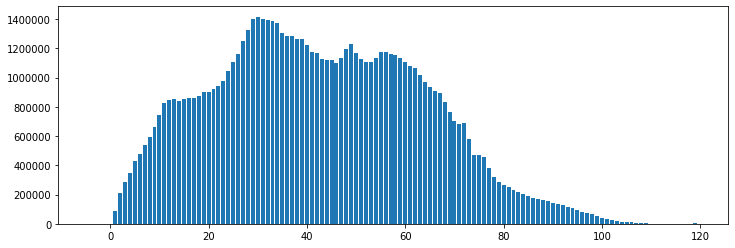

In [103]:
plt.figure(figsize=(12, 4))
ages = age_histogram()

## Fact count

In [19]:
def default_enroll_window(select_cols,
                          claims_table, 
                          claim_date_col,
                          enrollment_table='hy180.dbo.EnrollFourPlusYears', 
                          window_date_col='enrollDatePlusFourYears',
                          enroll_date_col='enrollDate',
                          join_col='MemberNum'):
    
    select_cols.append(f't1.{join_col}')
    return (f"select {','.join(select_cols)}"
       f" from {claims_table} as t1 inner join {enrollment_table} as t2"
       f" on t1.{join_col}=t2.{join_col}"
       f" where {claim_date_col} between {enroll_date_col} and {window_date_col}")

In [20]:
def fact_count_histogram(group_table=None, 
                         enrollment_table='hy180.dbo.EnrollFourPlusYears', 
                         window_date_col='enrollDatePlusFourYears', 
                         claims_table='ObservationDiagnosis',
                         claim_date_col='StartDate',
                         join_col='MemberNum',
                         cxn=cxn, 
                         ax=None, 
                         **plot_params):
    if group_table is None:
        query = ("drop table if exists hy180.dbo.memberFactCount;"
                " select t2.MemberNum, count(*) as factCount"
                " into hy180.dbo.memberFactCount"
               f" from (select {join_col}, {window_date_col} from {enrollment_table}) as t2"
               f"  inner join (select {join_col}, {claim_date_col} from {claims_table}) as t3"
               f"   on t2.{join_col}=t3.{join_col}"
               f" where {claim_date_col} < {window_date_col}"
               f" group by t2.{join_col}"
                )
    else:
        query = ("drop table if exists hy180.dbo.memberFactCount;"
                " select t2.MemberNum, count(*) as factCount"
                " into hy180.dbo.memberFactCount"
               f" from {group_table} as t1"
               f"  inner join (select {join_col}, {window_date_col} from {enrollment_table}) as t2"
               f"   on t1.{join_col}=t2.{join_col}"
               f"  inner join (select {join_col}, {claim_date_col} from {claims_table}) as t3"
               f"   on t2.{join_col}=t3.{join_col}"
               f" where {claim_date_col} < {window_date_col}"
               f" group by t2.{join_col}"
                )
    cxn.execute(query)
    
    hist_query = ("select factCount, count(*) as countCount"
                 " from hy180.dbo.memberFactCount"
                 " group by factCount")
        
    results = pd.read_sql(hist_query, cxn)
    if not ax: ax = plt.subplot(111)
    sns.distplot(results.factCount, hist_kws={'weights': results.countCount, 'log':True}, **plot_params)
    return results

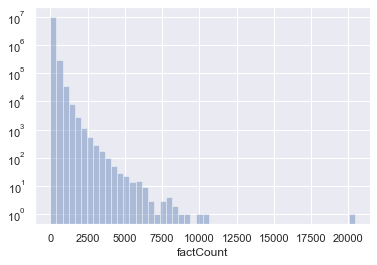

In [36]:
hist = fact_count_histogram()

# eMerge T2DM algorithm

In [21]:
glucose_tests_loinc = ('1558-6', '2339-0', '2345-7')
a1c_tests_loinc = ('4548-4', '17856-6', '4549-2', '17855-8')

glucose_max = 110.
a1c_max = 6.

abnormal_labs_query = ("drop table if exists #abnormalLabs;"
                      " select *"
                      " into #abnormalLabs"
                      " from GlucoseLabs"
                      " where (LoincCode in %s and TestResultValue > %f) or (LoincCode in %s and TestResultValue > %f)"
                       % (glucose_tests_loinc, glucose_max, a1c_tests_loinc, a1c_max))
hy_cxn.execute(abnormal_labs_query)
pd.read_sql('select count(*) from #abnormalLabs', hy_cxn)

,
0,3872080


## Cases

In [23]:
# t2d dx + rx for both t1d and t2d + first treated for t2d
gr1_query = ("drop table if exists #t2dCaseGroup1;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup1"
            " from (select MemberNum from DxT2dm) as t1"
            "      inner join (select MemberNum, min(DispenseDate) as firstRxT1dm from RxT1Dm group by MemberNum) as t2"
            "        on t1.MemberNum=t2.MemberNum"
            "      inner join (select MemberNum, min(DispenseDate) as firstRxT2dm from RxT2Dm group by MemberNum) as t3"
            "        on t2.MemberNum=t3.MemberNum"
            " where firstRxT2dm < firstRxT1dm"
            )
hy_cxn.execute(gr1_query)
print(hy_cxn.execute('select count(*) from #t2dCaseGroup1').fetchone()[0])

# t2d dx + rx for t2d but not t1d
gr2_query = ("drop table if exists #t2dCaseGroup2;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup2"
            " from (select distinct MemberNum from DxT2dm) as t1"
            "      inner join (select distinct MemberNum from RxT2Dm) as t2"
            "        on t1.MemberNum=t2.MemberNum;"
            " delete from #t2dCaseGroup2"
            " where MemberNum in (select MemberNum from RxT1Dm)"
            )
hy_cxn.execute(gr2_query)
print(hy_cxn.execute('select count(*) from #t2dCaseGroup2').fetchone()[0])

# t2d dx + no rx + abnormal labs
gr3_query = ("drop table if exists #t2dCaseGroup3;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup3"
            " from (select distinct MemberNum from DxT2dm) as t1"
            "      inner join (select distinct MemberNum from #abnormalLabs) as t2"
            "        on t1.MemberNum=t2.MemberNum;"
            " delete from #t2dCaseGroup3"
            " where MemberNum in (select MemberNum from RxT1Dm union select MemberNum from RxT2Dm)"
            )
hy_cxn.execute(gr3_query)
print(hy_cxn.execute('select count(*) from #t2dCaseGroup3').fetchone()[0])

# No t2d dx + t2d rx + abnormal lab
gr4_query = ("drop table if exists #t2dCaseGroup4;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup4"
            " from (select distinct MemberNum from #abnormalLabs) as t1"
            "      inner join (select distinct MemberNum from RxT2Dm) as t2"
            "        on t1.MemberNum=t2.MemberNum;"
            " delete from #t2dCaseGroup4"
            " where MemberNum in (select distinct MemberNum from DxT2dm)"
            )
hy_cxn.execute(gr4_query)
print(hy_cxn.execute('select count(*) from #t2dCaseGroup4').fetchone()[0])

# at least 2 separate t2d dx + rx for t1d but not t2d
gr5_query = ("drop table if exists #t2dCaseGroup5;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup5"
            " from (select distinct MemberNum, count(*) as totNumClaims from DxT2dm group by MemberNum) as t1"
            "      inner join (select distinct MemberNum from RxT1Dm) as t2"
            "        on t1.MemberNum=t2.MemberNum"
            " where totNumClaims > 1"
            " delete from #t2dCaseGroup2"
            " where MemberNum in (select MemberNum from RxT2Dm)"
            )
hy_cxn.execute(gr5_query)
print(hy_cxn.execute('select count(*) from #t2dCaseGroup5').fetchone()[0])


35452
216735
302626
8643
73930


In [24]:
case_query = ("drop table if exists t2dCaseEmerge;"
             " select distinct MemberNum"
             " into t2dCaseEmerge"
             " from (select * from #t2dCaseGroup1 union select * from #t2dCaseGroup2 union select * from #t2dCaseGroup3 union select * from #t2dCaseGroup4 union select * from #t2dCaseGroup5) as t1;"
             " delete from t2dCaseEmerge"
             " where MemberNum in (select MemberNum from DxT1dm)"
             )
hy_cxn.execute(case_query)

pd.read_sql('select count(*) from t2dCaseEmerge', hy_cxn)

,
0,289113


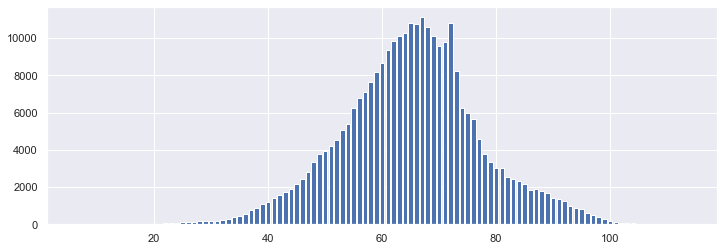

In [12]:
plt.figure(figsize=(12, 4))
dist = age_histogram(group_table='hy180.dbo.t2dCaseEmerge')

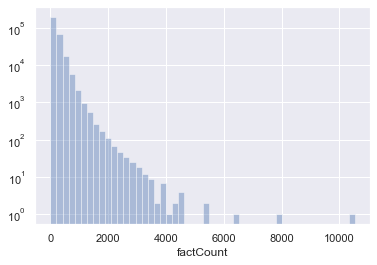

In [37]:
hist = fact_count_histogram(group_table='hy180.dbo.t2dCaseEmerge')

### Enrollment prior to first diagnosis

In [167]:
firstdx_query = ("drop table if exists #firstDx;"
               " select t1.MemberNum, min(date) as firstDxDate"
               " into #firstDx"
               " from t2dCaseEmerge as t1 inner join DxT2dm as t2"
               " on t1.MemberNum=t2.MemberNum"
               " group by t1.MemberNum"
                )
firstdxmonth_query = ("drop table if exists #firstDxMonth;"
               " select MemberNum, firstDxDate, EffectiveDate, OriginalEffectiveDate"
               " into #firstDxMonth"
               " from #firstDx as t1 inner join AetnaDataWarehouse.dbo.Enrollment as t2"
               " on MemberNum=CAST(MemberID AS BIGINT) and EffectiveDate=DATEADD(DAY, 1, EOMONTH(firstDxDate, -1)) "
                     )
denovo_query = ("drop table if exists #deNovo;"
               " select MemberNum, firstDxDate"
               " into #deNovo"
               " from #firstDxMonth"
               " where datediff(m, IIF(OriginalEffectiveDate > '20080101', OriginalEffectiveDate, '20080101'), EffectiveDate) > 9"
               )

hy_cxn.execute(';'.join([firstdx_query, firstdxmonth_query, denovo_query]))
pd.read_sql('select count(*) from #deNovo', hy_cxn)

,
0,76705


In [80]:
times = pd.read_sql("select datediff(m, IIF(OriginalEffectiveDate > '20080101', OriginalEffectiveDate, '20080101'), firstDxDate) from #firstDxMonth", hy_cxn)

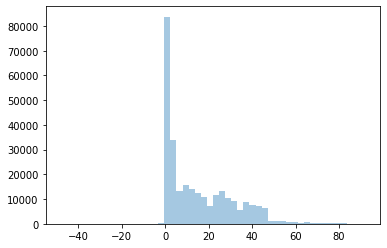

In [81]:
sns.distplot(times, kde=False)

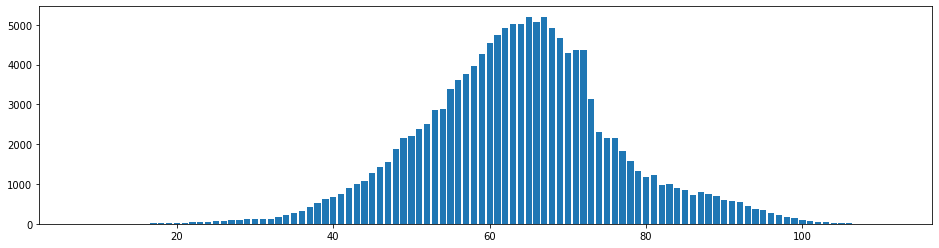

In [178]:
plt.figure(figsize=(16, 4))
dist = age_histogram('#deNovo', cxn=hy_cxn)

## Controls

In [25]:
# Keep patients with multiple visits & any glucose lab value 
pos_query = ("drop table if exists t2dControlEmerge;"
            " select t1.MemberNum"
            " into t2dControlEmerge"
            " from (select distinct MemberNum from VisitCount where visits > 1) as t1"
            " inner join (select distinct MemberNum from GlucoseLabs) as t2"
            " on t1.MemberNum=t2.MemberNum")

# Remove patients with DM dx (incl family hx) or abnormal labs
neg_query = ("delete from t2dControlEmerge"
            " where MemberNum in"
            " (select distinct MemberNum from DxDm"
            "  union select distinct MemberNum from #abnormalLabs"
            "  union select distinct MemberNum from RxDm)")

hy_cxn.execute(';'.join([pos_query, neg_query]))
pd.read_sql('select count(*) from t2dControlEmerge', hy_cxn)

,
0,2288032


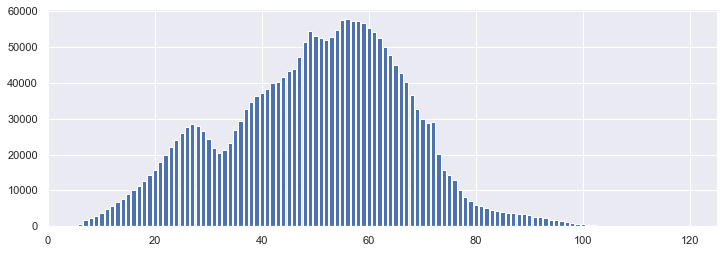

In [8]:
plt.figure(figsize=(12, 4))
dist = age_histogram(group_table='hy180.dbo.t2dControlEmerge')

### Ignoring lab tests

In [105]:
# Keep patients with multiple visits & any glucose lab value 
pos_query = ("drop table if exists t2dControlEmergeIgnoreLab;"
            " select t1.MemberNum"
            " into t2dControlEmergeIgnoreLab"
            " from (select distinct MemberNum from VisitCount where visits > 1) as t1"
            )

# Remove patients with DM dx (incl family hx)
neg_query = ("delete from t2dControlEmergeIgnoreLab"
            " where MemberNum in"
            " (select distinct MemberNum from DxDm"
            "  union select distinct MemberNum from RxDm)")

hy_cxn.execute(';'.join([pos_query, neg_query]))
pd.read_sql('select count(*) from t2dControlEmergeIgnoreLab', hy_cxn)

,
0,8062907


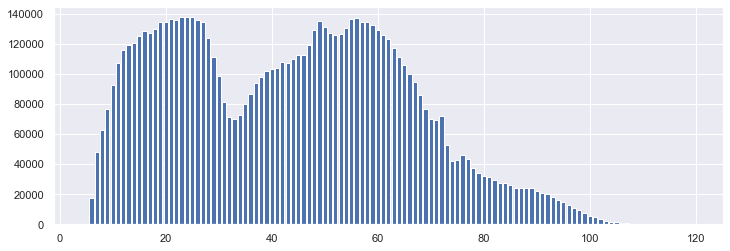

In [107]:
plt.figure(figsize=(12, 4))
hist = age_histogram(group_table='hy180.dbo.t2dControlEmergeIgnoreLab')

### Ignore lab value

In [170]:
pos_query = ("drop table if exists t2dControlEmergeIgnoreLabValue;"
            " select t1.MemberNum"
            " into t2dControlEmergeIgnoreLabValue"
            " from (select distinct MemberNum from VisitCount where visits > 1) as t1"
            " inner join (select distinct MemberNum from GlucoseLabs union select distinct MemberNum from GlucoseLabsCPT) as t2"
            " on t1.MemberNum=t2.MemberNum")

# Remove patients with DM dx (incl family hx) or abnormal labs
neg_query = ("delete from t2dControlEmergeIgnoreLabValue"
            " where MemberNum in"
            " (select distinct MemberNum from DxDm"
            "  union select distinct MemberNum from RxDm)")

hy_cxn.execute(';'.join([pos_query, neg_query]))
pd.read_sql('select count(*) from t2dControlEmergeIgnoreLabValue', hy_cxn)

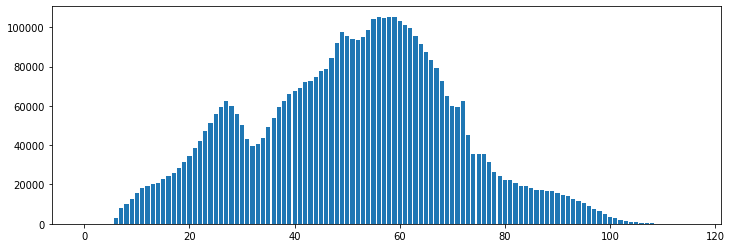

In [22]:
plt.figure(figsize=(12, 4))
hist = age_histogram(group_table='hy180.dbo.t2dControlEmergeIgnoreLabValue')

### No lab test

In [109]:
# Keep patients with multiple visits & any glucose lab value 
pos_query = ("drop table if exists t2dControlEmergeNoLab;"
            " select t1.MemberNum"
            " into t2dControlEmergeNoLab"
            " from (select distinct MemberNum from VisitCount where visits > 1) as t1"
            )

# Remove patients with DM dx (incl family hx) and documented lab test
neg_query = ("delete from t2dControlEmergeNoLab"
            " where MemberNum in"
            " (select distinct MemberNum from DxDm"
            "  union select distinct MemberNum from RxDm"
            "  union select distinct MemberNum from GlucoseLabs"
            "  union select distinct MemberNum from GlucoseLabsCPT)"
            )

hy_cxn.execute(';'.join([pos_query, neg_query]))
pd.read_sql('select count(*) from t2dControlEmergeNoLab', hy_cxn)

,
0,3397361


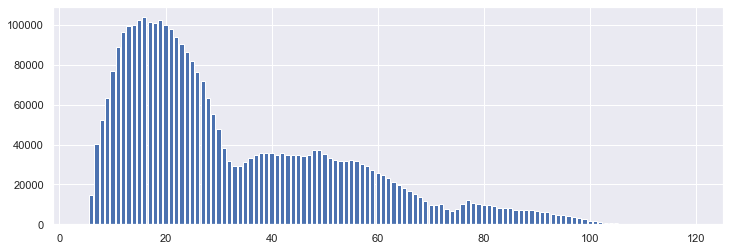

In [110]:
plt.figure(figsize=(12, 4))
hist = age_histogram(group_table='hy180.dbo.t2dControlEmergeNoLab')

### Single visit count

In [28]:
# Keep patients with single visit & any glucose lab value 
pos_query = ("drop table if exists t2dControlEmergeSingleVisit;"
            " select t1.MemberNum"
            " into t2dControlEmergeSingleVisit"
            " from (select distinct MemberNum from VisitCount) as t1"
            " inner join (select distinct MemberNum from GlucoseLabs) as t2"
            " on t1.MemberNum=t2.MemberNum")

# Remove patients with DM dx (incl family hx) or abnormal labs
neg_query = ("delete from t2dControlEmergeSingleVisit"
            " where MemberNum in"
            " (select distinct MemberNum from DxDm"
            "  union select distinct MemberNum from #abnormalLabs"
            "  union select distinct MemberNum from RxDm)")

hy_cxn.execute(';'.join([pos_query, neg_query]))
pd.read_sql('select count(*) from t2dControlEmergeSingleVisit', hy_cxn)

,
0,2295455


<BarContainer object of 110 artists>

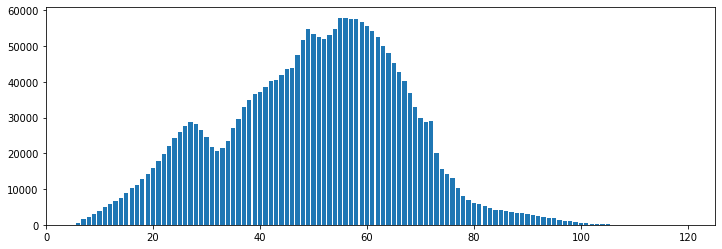

In [51]:
plt.figure(figsize=(12, 4))
age_histogram(group_table='hy180.dbo.t2dControlEmergeSingleVisit')

### Ignoring screening ICD (V77.1)

In [29]:
dm_dx_icd = str(('790.21', '790.22', '790.2', '790.29', '791.5', '277.7', 'V18.0'))
dm_dx_icd_fuzzy_match = ' or '.join(["diagCode like '%s'" % s for s in ('250%', '648.8%', '648.0%')])

# Keep patients with single visit & any glucose lab value 
pos_query = ("drop table if exists t2dControlEmergeNoScreening;"
            " select t1.MemberNum"
            " into t2dControlEmergeNoScreening"
            " from (select distinct MemberNum from VisitCount where visits > 1) as t1"
            " inner join (select distinct MemberNum from GlucoseLabs) as t2"
            " on t1.MemberNum=t2.MemberNum")

# Remove patients with DM dx (incl family hx) or abnormal labs
neg_query = ("delete from t2dControlEmergeNoScreening"
            " where MemberNum in"
           f" (select distinct MemberNum from DxDm where diagCode in {dm_dx_icd} or {dm_dx_icd_fuzzy_match}"
            "  union select distinct MemberNum from #abnormalLabs"
            "  union select distinct MemberNum from RxDm)")

hy_cxn.execute(';'.join([pos_query, neg_query]))
pd.read_sql('select count(*) from t2dControlEmergeNoScreening', hy_cxn)

,
0,2358527


### Ignoring family history of dm (V18.0)

In [30]:
dm_dx_icd = str(('790.21', '790.22', '790.2', '790.29', '791.5', '277.7', 'V77.1'))
dm_dx_icd_fuzzy_match = ' or '.join(["diagCode like '%s'" % s for s in ('250%', '648.8%', '648.0%')])

# Keep patients with single visit & any glucose lab value 
pos_query = ("drop table if exists t2dControlEmergeNoFamilyHx;"
            " select t1.MemberNum"
            " into t2dControlEmergeNoFamilyHx"
            " from (select distinct MemberNum from VisitCount where visits > 1) as t1"
            " inner join (select distinct MemberNum from GlucoseLabs) as t2"
            " on t1.MemberNum=t2.MemberNum")

# Remove patients with DM dx (incl family hx) or abnormal labs
neg_query = ("delete from t2dControlEmergeNoFamilyHx"
            " where MemberNum in"
           f" (select distinct MemberNum from DxDm where diagCode in {dm_dx_icd} or {dm_dx_icd_fuzzy_match}"
            "  union select distinct MemberNum from #abnormalLabs"
            "  union select distinct MemberNum from RxDm)")

hy_cxn.execute(';'.join([pos_query, neg_query]))
pd.read_sql('select count(*) from t2dControlEmergeNoFamilyHx', hy_cxn)

,
0,2321623


# Depression

## Cases

In [31]:
depression_cases_query = ("drop table if exists depressionCase;"
                         " select distinct MemberNum"
                         " into depressionCase"
                         " from dxDepression")
hy_cxn.execute(depression_cases_query)
pd.read_sql('select count(*) from depressionCases', hy_cxn)

,
0,1136743


### Multiple diagnoses

In [32]:
depression_cases_query = ("drop table if exists depressionCaseMultipledx;"
                         " select MemberNum"
                         " into depressionCaseMultipledx"
                         " from (select MemberNum, count(*) as dxCount from dxDepression group by MemberNum) as t"
                         " where dxCount > 1")
hy_cxn.execute(depression_cases_query)
pd.read_sql('select count(*) from depressionCaseMultipledx', hy_cxn)

,
0,779272


## Controls

In [33]:
depression_control_query = ("drop table if exists depressionControl;"
                         " select distinct MemberNum"
                         " into depressionControl"
                         " from EnrollFourPlusYears;"
                         " delete from depressionControl"
                         " where MemberNum in (select MemberNum from depressionCases)")

hy_cxn.execute(depression_control_query)
pd.read_sql('select count(*) from depressionControl', hy_cxn)

,
0,9409473


# Association Testing

In [13]:
def count_overlap(t1, t2, key_col, cxn):
    query = ("select count(*)"
            " from %s as t1 inner join %s as t2 on t1.%s=t2.%s"
            % (t1, t2, key_col, key_col))
    return cxn.execute(query).fetchone()[0]

def matched_control_query(case_table, control_pop_table, demo_table='gmw3.dbo.Member', subsample=None):
    query = ("drop table if exists #control;"
            " with cteCaseType as"
            " (select t1.MemberNum, Gender, BirthYearMinus1900, row_number() over (partition by Gender, BirthYearMinus1900 order by newid()) as CaseRN"
           f"  from {case_table} as t1 inner join {demo_table} as t2 on t1.MemberNum=t2.MemberNum),"
            " cteControlType as"
            "  (select t1.MemberNum, Gender, BirthYearMinus1900, row_number() over (partition by Gender, BirthYearMinus1900 order by newid()) as ControlRN"
           f"   from {control_pop_table} as t1 inner join {demo_table} as t2 on t1.MemberNum=t2.MemberNum)"
            " select t2.MemberNum"
            " into #control"
            " from cteCaseType as t1 inner join"
            " cteControlType as t2 on t1.BirthYearMinus1900=t2.BirthYearMinus1900 and t1.gender=t2.gender and CaseRN=ControlRN"
            )
    return query

def unmatched_control_query(case_table, control_pop_table, subsample=None):
    query = (f"drop table if exists #control;"
            f" select {('top %d' % subsample) if subsample else ''} t1.MemberNum into #control" 
            f"from {control_table} as t1 inner join {studypop_table} as t2 on t1.MemberNum=t2.MemberNum"
            )
    return query
    
def contingency_table(case_table, control_table, exposed_table, nonexposed_table, control_query=matched_control_query, studypop_table=None, subsample=None, cxn=hy_cxn):
    if not studypop_table:
        cxn.execute('drop table if exists #studyPop; select MemberNum into #studyPop from ((select MemberNum from %s union select MemberNum from %s) intersect (select MemberNum from %s union select MemberNum from %s)) as t'
                   % (case_table, control_table, exposed_table, nonexposed_table))
        studypop_table = '#studyPop'
    cxn.execute(f"drop table if exists #case; select {('top %d' % subsample) if subsample else ''} t1.MemberNum into #case from {case_table} as t1 inner join {studypop_table} as t2 on t1.MemberNum=t2.MemberNum")
    cxn.execute(matched_control_query('#case', control_table))
   
    case_exposed = count_overlap('#case', exposed_table, 'MemberNum', cxn)
    case_nonexposed = count_overlap('#case', nonexposed_table, 'MemberNum', cxn)
    control_exposed = count_overlap('#control', exposed_table, 'MemberNum', cxn)
    control_nonexposed = count_overlap('#control', nonexposed_table, 'MemberNum', cxn)
    
    return np.asarray([[case_exposed, control_exposed], [case_nonexposed, control_nonexposed]])

## Baseline groups
* Case: eMERGE
* Control: eMERGE
* exposure: Depression 1x CCS dx
* non-exposure: Continuous enrollment with no depression dx


In [23]:
ors = []
p_values = []

t = contingency_table('t2dCaseEmerge', 't2dControlEmergeIgnoreLab', 'depressionCase', 'depressionControl')
oddsr, p_value = stats.fisher_exact(t)
ors.append(oddsr)
p_values.append(p_value)

In [24]:
print(ors, p_values)

[1.3618638670893208] [0.0]


In [25]:
stats.fisher_exact(t)

(1.3618638670893208, 0.0)

In [26]:
ctable(t).oddsratio_confint()

(1.341910196492637, 1.3821142408270295)

## Alternate definitions

In [7]:
case_groups = ['t2dCaseEmerge']
control_groups = ['t2dControlEmergeIgnoreLabValue']
# control_groups = ['t2dControlEmerge', 't2dControlEmergeIgnoreLab', 't2dControlEmergeSingleVisit', 't2dControlEmergeNoScreening', 't2dControlEmergeNoFamilyHx']
exposure_groups = ['depressionCase']
nonexposure_groups = ['depressionControl']

samp_size = 2000
n_samps = 200
results = pd.DataFrame(columns=['control', 'samp_size', 'OR', 'p_value', 'ci95_lower', 'ci95_upper'], 
                       index=np.arange(0, len(case_groups) * len(control_groups) * len(exposure_groups) * len(nonexposure_groups) * n_samps))

for i, comb in tqdm(enumerate(itertools.product(*[case_groups, control_groups, exposure_groups, nonexposure_groups]))):
    for j in tqdm(range(n_samps)):
        tab = contingency_table(*comb, subsample=samp_size)
        fe_test = stats.fisher_exact(tab)
        or_ci = ctable(tab).oddsratio_confint()

        results.iloc[i*n_samps + j] = [comb[1], samp_size, fe_test[0], fe_test[1], or_ci[0], or_ci[1]]

results.to_csv('results/ignoreLabValueFixed_definitions_bootstrap.csv')

[Text(0, 0, 't2dControlEmergeIgnoreLabValue')]

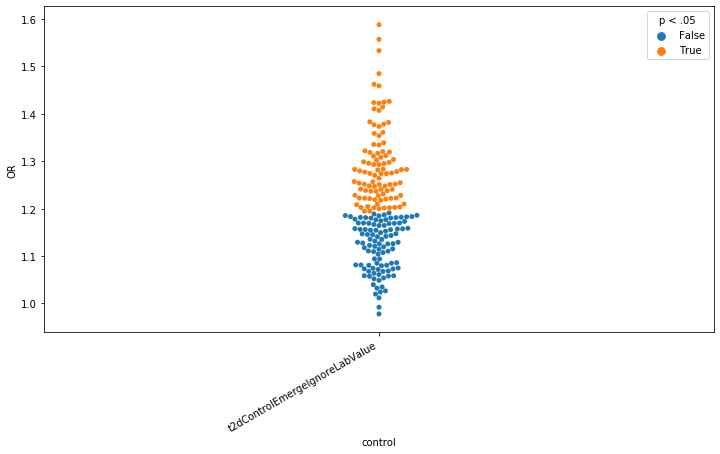

In [9]:
# results = pd.read_csv('results/control_definitions_bootstrap.csv')
results['p < .05'] = results.p_value < .05

plt.figure(figsize=(12, 6))
ax = sns.swarmplot(data=results[results.samp_size==2000], x='control', y='OR', hue='p < .05')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

## Multithreaded experiments

In [14]:
def single_test(groups, samp_size, i, matching=False):
    control_query = matched_control_query if matching else unmatched_control_query
    
    with hy_engine.connect() as test_cxn:
        tab = contingency_table(*groups, subsample=samp_size, cxn=test_cxn, control_query=control_query)
    
    fe_test = stats.fisher_exact(tab)
    or_ci = ctable(tab).oddsratio_confint()

    return (groups[1], samp_size, fe_test[0], fe_test[1], or_ci[0], or_ci[1])

In [ ]:
case_groups = ['t2dCaseEmerge']
# control_groups = ['t2dControlEmerge', 't2dControlEmergeIgnoreLab', 't2dControlEmergeSingleVisit', 't2dControlEmergeNoScreening', 't2dControlEmergeNoFamilyHx']
control_groups = ['t2dControlEmergeIgnoreLabValue']
exposure_groups = ['depressionCase']
nonexposure_groups = ['depressionControl']

group_combs = itertools.product(case_groups, control_groups, exposure_groups, nonexposure_groups)
samp_sizes = [2000, 10000]
n_samps = 200

num_workers = 4

def process(inQ, outQ):
    for args in iter(inQ.get, None):
        result = single_test(*args)
        outQ.put(result)

manager = mp.Manager()
toRun = manager.Queue()
toReturn = manager.Queue()
result = []

[toRun.put(arrayElem) for arrayElem in itertools.product(group_combs, samp_sizes, range(n_samps))]
[toRun.put(None) for i in range(num_workers)]

processes = [Process(target=process, args=(toRun, toReturn)) for i in range(num_workers)]
[p.start() for p in processes]
[p.join() for p in processes]

while not toReturn.empty():
    smallResult = toReturn.get()
    result.append(smallResult)
    
df = pd.DataFrame(columns=['control', 'samp_size', 'OR', 'p_value', 'ci95_lower', 'ci95_upper'], data=result)
df.to_csv('results/matched_ignoreLabValueFixed_definitions_bootstrap.csv')

Process Process-2:
Process Process-3:
Traceback (most recent call last):


[Text(0, 0, 'Baseline'),
 Text(0, 0, 'Ignore Lab Result'),
 Text(0, 0, 'Ignore Lab'),
 Text(0, 0, 'No Lab')]

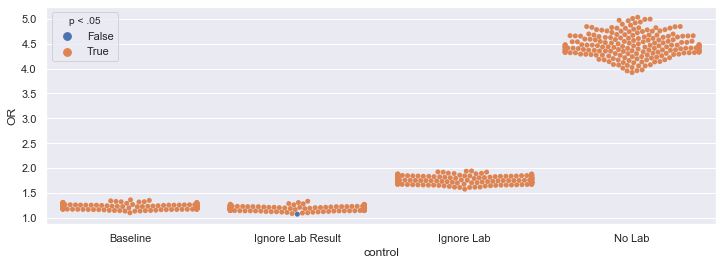

In [4]:
results = pd.read_csv('results/lab_controls_bootstrap.csv')
results['p < .05'] = results.p_value < .05
results['ci_width'] = results.ci95_upper - results.ci95_lower

plt.figure(figsize=(12, 4))
sns.set()
ax = sns.swarmplot(data=results[results.samp_size==10000], x='control', y='OR', hue='p < .05', order=['t2dControlEmerge', 't2dControlEmergeIgnoreLabValue', 't2dControlEmergeIgnoreLab', 't2dControlEmergeNoLab'])
ax.set_xticklabels(['Baseline', 'Ignore Lab Result', 'Ignore Lab', 'No Lab'], ha='center')

In [5]:
results[results.control=='t2dControlEmerge'].mean()

Unnamed: 0     399.565000
samp_size     4500.000000
OR               1.225672
p_value          0.097069
ci95_lower       1.054908
ci95_upper       1.430062
p < .05          0.725000
ci_width         0.375154
dtype: float64